# Navigation

---

In this notebook, we will use the Unity ML-Agents environment 
for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

Notes related to project are in the `README.md` file

### 1. Start the Environment

Importing some necessary packages.  
If the code cell below returns an error, please revisit the project 
instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
from collections import deque
import numpy as np
import torch
import sys
import os

import matplotlib.pyplot as plt
%matplotlib inline

LOCAL_PATH = '/Users/youval.dar/Documents/workspace/deep-reinforcement-learning/Udacity-p1_navigation'

Start the environment!  
**_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  
If this file is in the same folder as the notebook, then the line below should appear as follows:

**Also** note that on Mac you might need to add the options `worker_id=2, seed=1` otherwise the app might freeze   
```
env = UnityEnvironment(file_name="Banana.app", worker_id=2, seed=1)
```

### 2. Examine the State and Action Spaces

In [2]:
env = UnityEnvironment(file_name=os.path.join(LOCAL_PATH,"Banana.app"),worker_id=2, seed=1)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. 
Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
print('Brain name:', brain_name)
brain = env.brains[brain_name]

Brain name: BananaBrain



The simulation contains a single agent that navigates a large environment.  
At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects 
around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, 
and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [0.         1.         0.         0.         0.27946243 0.
 1.         0.         0.         0.74556106 0.         0.
 1.         0.         0.48277503 0.         1.         0.
 0.         0.30341193 0.         0.         1.         0.
 0.46494457 0.         0.         1.         0.         0.08466676
 0.         1.         0.         0.         0.95967758 0.
 0.        ]
States have length: 37


### Average games scores info when playing multiple using uniformly random action selection
When using the Python API to control the agent and receive feedback from the environment,
when the next cell run and selects an action (uniformly) at random we got average score of over 100 runs.  

**_Note_** Change `n_episodes` to the number of random games you want to run

In [ ]:
scores = []
n_episodes = 10
for i in range(n_episodes):
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0                                          # initialize the score
    done = False                                       # episode finished
    while not done:
        action = np.random.randint(action_size)        # select an action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
    
    print("{}: Score: {}".format(i+1, score))
    sys.stdout.flush()
    scores.append(score)
    
# Print games summary
scores = np.array(scores)
print('Uniformly random action')
print('-----------------------')
print('Avg score:',np.average(scores) )
print('Min score:', np.min(scores))
print('Max score:', np.max(scores))
print('Median score:', np.median(scores))

1: Score: 0.0
2: Score: 0.0
3: Score: -1.0
4: Score: 3.0
5: Score: -3.0
6: Score: 0.0
7: Score: 1.0
8: Score: 2.0


In one of teh past random runs, for 10 games we got:
* Avg score: 0.2
* Min score: -1.0
* Max score: 1.0
* Median score: 0.0

In [ ]:
env.close()

### Using RL to play better...

In the next few cells we will:  
- Improve model using experience from playing the game
- Save the model 
- Collect number of games score average (and compare to the average score we got when using random action)  

In [3]:
# Import tools 
# from Navigation_tools import BananaGame

from dqn_agent import Agent
LOCAL_PATH = '/Users/youval.dar/Documents/workspace/deep-reinforcement-learning/Udacity-p1_navigation'

In [4]:
class BananaGame():

    def __init__(self):
        self.env = None
        self.brain = None
        self.brain_name = None
        self.agent = None

    def start_env(self):
        self.env = UnityEnvironment(file_name=os.path.join(LOCAL_PATH, "Banana.app"), worker_id=2, seed=1)
        self.brain_name = self.env.brain_names[0]
        self.brain = self.env.brains[self.brain_name]
        return self.env

    @staticmethod
    def print_scores_stats(scores):
        """
        Prints basic states of data in the list "scores"

        Args:
            scores (list): list of scores
        """
        scores = np.array(scores)
        print('Actions info')
        print('-----------------------')
        print('Avg score: {:.2f}'.format(np.average(scores)))
        print('Min score:', np.min(scores))
        print('Max score:', np.max(scores))
        print('Median score:', np.median(scores))

    def uniform_random(self, n_episodes=10):
        env = self.start_env()
        print('Brain name:', self.brain_name)
        env_info = env.reset(train_mode=True)[self.brain_name]

        # number of agents in the environment
        print('Number of agents:', len(env_info.agents))
        # number of actions
        action_size = self.brain.vector_action_space_size
        print('Number of actions:', action_size)
        # examine the state space
        state = env_info.vector_observations[0]
        print('States look like:', state)
        state_size = len(state)
        print('States have length:', state_size)

        scores = []
        for i in range(n_episodes):
            print('Game:', i + 1)
            env_info = env.reset(train_mode=False)[self.brain_name]  # reset the environment
            state = env_info.vector_observations[0]  # get the current state
            score = 0  # initialize the score
            done = False  # episode finished
            while not done:
                action = np.random.randint(action_size)  # select an action
                env_info = env.step(action)[self.brain_name]  # send the action to the environment
                next_state = env_info.vector_observations[0]  # get the next state
                reward = env_info.rewards[0]  # get the reward
                done = env_info.local_done[0]  # see if episode has finished
                score += reward  # update the score
                state = next_state  # roll over the state to next time step

            print("{}: Score: {}".format(i + 1, score))
            sys.stdout.flush()
            scores.append(score)

        # Print games summary
        self.print_scores_stats(scores)
        self.env.close()

    def training_model(self, model_num=1):
        # Using DQN from the file dqn_agent.py
        env = self.start_env()

        # reset the environment
        env_info = env.reset(train_mode=True)[self.brain_name]
        state = env_info.vector_observations[0]
        state_size = len(state)
        action_size = self.brain.vector_action_space_size

        # Set agent params
        agent = Agent(
            state_size=state_size,
            action_size=action_size,
            seed=0,
            model_num=model_num)

        scores = self.dqn(agent, model_num=model_num)
        self.env.close()
        return scores

    def dqn(self, agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, model_num=1):
        """Deep Q-Learning.

        Params
        ======
            n_episodes (int): maximum number of training episodes
            max_t (int): maximum number of timesteps per episode
            eps_start (float): starting value of epsilon, for epsilon-greedy action selection
            eps_end (float): minimum value of epsilon
            eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        """
        scores = []  # list containing scores from each episode
        scores_window = deque(maxlen=100)  # last 100 scores
        eps = eps_start  # initialize epsilon
        for i_episode in range(1, n_episodes + 1):
            env_info = self.env.reset(train_mode=False)[self.brain_name]
            state = env_info.vector_observations[0]
            score = 0
            for t in range(max_t):
                action = agent.act(state, eps)
                env_info = self.env.step(action)[self.brain_name]  # send the action to the environment
                next_state = env_info.vector_observations[0]  # get the next state
                reward = env_info.rewards[0]  # get the reward
                done = env_info.local_done[0]
                agent.step(state, action, reward, next_state, done)
                state = next_state
                score += reward
                if done:
                    break
            scores_window.append(score)  # save most recent score
            scores.append(score)  # save most recent score
            eps = max(eps_end, eps_decay * eps)  # decrease epsilon
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
            if i_episode % 100 == 0:
                print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            if np.mean(scores_window) >= 15.5:
                str_out = '\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'
                print(str_out.format(i_episode - 100, np.mean(scores_window)))

                if model_num == 1:
                    fn = 'checkpoint.pth'
                else:
                    fn = 'checkpoint_dropout.pth'
                fn = os.path.join(LOCAL_PATH, fn)
                torch.save(agent.qnetwork_local.state_dict(), fn)
                break
        return scores

    def trained_model(self, n_episodes=10, model_num=1):
        # reset the environment
        env = self.start_env()
        env_info = env.reset(train_mode=False)[self.brain_name]
        state = env_info.vector_observations[0]
        state_size = len(state)
        action_size = self.brain.vector_action_space_size

        # Set agent params
        agent = Agent(
            state_size=state_size,
            action_size=action_size,
            seed=0,
            model_num=model_num)

        # load the weights from file
        if model_num == 1:
            fn = 'checkpoint.pth'
        else:
            fn = 'checkpoint_dropout.pth'
        fn = os.path.join(LOCAL_PATH, fn)
        agent.qnetwork_local.load_state_dict(torch.load(fn))

        scores = []
        for i in range(n_episodes):
            env_info = env.reset(train_mode=False)[self.brain_name]  # reset the environment
            state = env_info.vector_observations[0]  # get the current state
            score = 0  # initialize the score
            done = False
            while not done:
                action = agent.act(state)
                env_info = env.step(action)[self.brain_name]  # send the action to the environment
                next_state = env_info.vector_observations[0]  # get the next state
                reward = env_info.rewards[0]  # get the reward
                done = env_info.local_done[0]  # see if episode has finished
                score += reward  # update the score
                state = next_state  # roll over the state to next time step

            print("{}: Score: {}".format(i + 1, score))
            sys.stdout.flush()
            scores.append(score)

        # Print games summary
        self.print_scores_stats(scores)
        self.env.close()
        return scores

    def plot_scores(self, scores):
        """
        plot the scores

        Args:
            scores (list): List of scores
        """
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(scores)), scores)
        plt.ylabel('Score')
        plt.xlabel('Episode #')
        plt.show()


In [6]:
o = BananaGame()

#### Traing usign DQN with 3 linear layers (Model QNetwork in model.py)

In [11]:
# To run the random model uncomment the line below
# o.uniform_random(3)

In [ ]:
# Train model (model will be saved to checkpoint.pth when average score gets to 15.5)
scores = o.training_model(model_num=1)

In [ ]:
# Ploting the scores
# o.plot_scores(scores)

#### Traing usign DQN with 3 larger linear layers and dropout layers (Model QNetwork2 in model.py)

In [5]:
# Train model (model will be saved to checkpoint.pth when average score gets to 15.5)
scores = o.training_model(model_num=2)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Episode 2	Average Score: 0.50

#### Run 100 using the DQN trained model

__Past run info__   
Avg score: 16.95   
Min score: 0.0   
Max score: 24.0   
Median score: 17.0   

![DQN Trained model](DQN_image.png)

In [ ]:
scores = o.trained_model(100, model_num=1)
o.plot_scores(scores)

#### Run 100 using the DQN + Dropout trained model

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


1: Score: 13.0
2: Score: 18.0
3: Score: 15.0
4: Score: 12.0
5: Score: 15.0
6: Score: 17.0
7: Score: 14.0
8: Score: 15.0
9: Score: 19.0
10: Score: 14.0
11: Score: 14.0
12: Score: 10.0
13: Score: 17.0
14: Score: 13.0
15: Score: 10.0
16: Score: 13.0
17: Score: 14.0
18: Score: 20.0
19: Score: 16.0
20: Score: 15.0
21: Score: 16.0
22: Score: 16.0
23: Score: 19.0
24: Score: 13.0
25: Score: 18.0
26: Score: 21.0
27: Score: 14.0
28: Score: 11.0
29: Score: 16.0
30: Score: 18.0
31: Score: 17.0
32: Score: 14.0
33: Score: 15.0
34: Score: 10.0
35: Score: 14.0
36: Score: 12.0
37: Score: 15.0
38: Score: 13.0
39: Score: 19.0
40: Score: 14.0
41: Score: 17.0
42: Score: 16.0
43: Score: 21.0
44: Score: 15.0
45: Score: 14.0
46: Score: 15.0
47: Score: 17.0
48: Score: 13.0
49: Score: 22.0
50: Score: 18.0
51: Score: 13.0
52: Score: 20.0
53: Score: 13.0
54: Score: 15.0
55: Score: 18.0
56: Score: 21.0
57: Score: 21.0
58: Score: 20.0
59: Score: 22.0
60: Score: 8.0
61: Score: 10.0
62: Score: 12.0
63: Score: 17.0
64

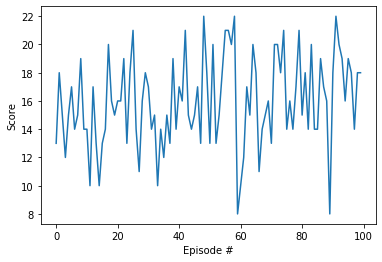

In [7]:
scores = o.trained_model(100, model_num=2)
o.plot_scores(scores)